In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import sys
sys.path.append("../")
import ionopy
from ionopy import MadrigalDatasetTimeSeries, weight_init, mae_loss

import pandas as pd
import torch
from omegaconf import OmegaConf
from tft_torch import tft
import tft_torch.loss as tft_loss
import torch.nn.init as init
import numpy as np
import wandb
from pyfiglet import Figlet
from termcolor import colored
from tqdm import tqdm

from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
import random

import re



In [42]:
base_path = '/home/ga00693/gcs-bucket/tft_models'
model_paths_single_names = os.listdir(base_path)
model_paths = [os.path.join(base_path, mp) for mp in model_paths_single_names if mp.endswith('.pth')]


In [43]:
import wandb

# Create an API object
api = wandb.Api()



In [65]:
run.config['no_timed']

True

In [64]:
list(run.config.keys())

['lr',
 'seed',
 'device',
 'epochs',
 'dropout',
 'no_jpld',
 'no_timed',
 'run_name',
 'loss_type',
 'no_set_sw',
 'batch_size',
 'bucket_dir',
 'model_path',
 'model_type',
 'state_size',
 'torch_type',
 'lstm_layers',
 'num_workers',
 'subset_type',
 'learning_rate',
 'no_celestrack',
 'lag_days_timed',
 'wandb_inactive',
 'attention_heads',
 'jpld_resolution',
 'no_omni_indices',
 'omni_resolution',
 'lag_days_proxies',
 'lag_minutes_jpld',
 'lag_minutes_omni',
 'timed_resolution',
 'no_omni_solar_wind',
 'num_future_numeric',
 'num_static_numeric',
 'proxies_resolution',
 'no_omni_magnetic_field',
 'num_historical_numeric']

In [55]:
model_paths_single_names[0][:-3]

'FalseFalseFalseFalseTrueTrueTrue_tft_10mln_2025-08-21_23-32-04_Batch256_LSTM2_Att2_SS64.'

In [56]:
api = wandb.Api()
runs = api.runs("ionocast/ionopy")

for run in runs:
    if run.name == model_paths_single_names[0][:-4] or run.name == model_paths_single_names[0][5:-4]:
        print(run.config["model_type"], run.config["batch_size"])

tft 256


In [29]:
import datetime
dates=[]
#extract the daate from here: ['/home/ga00693/gcs-bucket/tft_models/TrueTrueTrueTrueTrueTrue_tft_10mln_2025-08-21_23-15-50_Batch256_LSTM2_Att2_SS64.pth',
for model_path in model_paths:
    dates.append(datetime.datetime.strptime(model_path.split('_')[4] + ' ' + model_path.split('_')[5], '%Y-%m-%d %H-%M-%S'))

#now re-order the model path according to the. dates sorted in reverse:
model_paths = [x for _, x in sorted(zip(dates, model_paths), reverse=True)]

In [30]:
model_paths

['/home/ga00693/gcs-bucket/tft_models/FalseTrueFalseTrueFalseFalseFalse_tft_20mln_2025-10-13_11-21-42_Batch512_LSTM2_Att2_SS64.pth',
 '/home/ga00693/gcs-bucket/tft_models/FalseTrueFalseTrueFalseFalseFalse_tft_10mln_2025-10-13_11-21-28_Batch512_LSTM2_Att2_SS64.pth',
 '/home/ga00693/gcs-bucket/tft_models/FalseFalseTrueTrueFalseFalseFalse_tft_10mln_2025-10-13_08-57-39_Batch256_LSTM2_Att2_SS64.pth',
 '/home/ga00693/gcs-bucket/tft_models/FalseFalseTrueTrueFalseFalseFalse_tft_10mln_2025-10-13_08-57-36_Batch256_LSTM2_Att2_SS64.pth',
 '/home/ga00693/gcs-bucket/tft_models/FalseFalseTrueFalseFalseFalseFalse_tft_10mln_2025-10-13_08-57-33_Batch256_LSTM2_Att2_SS64.pth',
 '/home/ga00693/gcs-bucket/tft_models/FalseFalseTrueFalseFalseFalseFalse_tft_10mln_2025-10-13_08-57-30_Batch256_LSTM2_Att2_SS64.pth',
 '/home/ga00693/gcs-bucket/tft_models/FalseFalseTrueFalseFalseFalseFalse_tft_10mln_2025-10-13_08-57-27_Batch256_LSTM2_Att2_SS64.pth',
 '/home/ga00693/gcs-bucket/tft_models/FalseFalseTrueFalseFalseFals

In [2]:
#add the base dir to the path:
lags_res_dict={}
#we store them as: lag_days, res_days, lag_minutes, res_minutes

lags_res_dict[os.path.join(base_path,'TrueTrueTrueTrueTrueTrue_tft_10mln_2025-08-21_23-15-50_Batch256_LSTM2_Att2_SS64.pth')]=[144, 1, 8640, 60]
lags_res_dict[os.path.join(base_path,'FalseTrueFalseTrueTrueTrueTrue_tft_10mln_2025-08-25_12-25-36_Batch256_LSTM2_Att2_SS32.pth')]=[144,1,8640,60]
lags_res_dict[os.path.join(base_path,'FalseTrueFalseTrueFalseFalseFalse_tft_10mln_2025-08-25_12-32-35_Batch256_LSTM2_Att2_SS32.pth')]=[81, 1, 8640, 60]
lags_res_dict[os.path.join(base_path,'TrueTrueFalseTrueTrueTrue_tft_10mln_2025-08-21_23-13-38_Batch256_LSTM2_Att2_SS64.pth')]=[144, 1, 8640, 60]
lags_res_dict[os.path.join(base_path,'TrueFalseFalseTrueTrueTrueTrue_tft_10mln_2025-08-21_23-13-17_Batch256_LSTM2_Att2_SS64.pth')]=[144, 1, 8640, 60]
lags_res_dict[os.path.join(base_path,'TrueFalseTrueTrueTrueTrueFalse_tft_10mln_2025-08-21_23-14-31_Batch256_LSTM2_Att2_SS64.pth')]=[144, 1, 8640, 60]
lags_res_dict[os.path.join(base_path,'TrueFalseTrueFalseTrueTrueTrue_tft_10mln_2025-08-21_23-13-38_Batch256_LSTM2_Att2_SS64.pth')]=[144, 1, 8640, 60]
lags_res_dict[os.path.join(base_path,'FalseFalseFalseFalseTrueTrueTrue_tft_10mln_2025-08-21_23-32-04_Batch256_LSTM2_Att2_SS64.pth')]=[144, 1, 8640, 60]
lags_res_dict[os.path.join(base_path,'FalseFalseFalseTrueTrueTrueTrue_tft_10mln_2025-08-21_23-25-08_Batch256_LSTM2_Att2_SS64.pth')]=[144, 1, 8640, 60]
lags_res_dict[os.path.join(base_path,'FalseTrueFalseTrueTrueTrueTrue_tft_10mln_2025-08-25_12-33-49_Batch256_LSTM2_Att2_SS32.pth')]=[108,1,6480,60]
lags_res_dict[os.path.join(base_path,'FalseTrueFalseTrueTrueTrueTrue_tft_10mln_2025-08-25_12-28-30_Batch256_LSTM2_Att2_SS32.pth')]=[54, 1, 3240, 60]
lags_res_dict[os.path.join(base_path,'FalseTrueFalseTrueTrueTrueTrue_tft_10mln_2025-08-25_12-34-57_Batch256_LSTM2_Att2_SS32.pth')]=[135, 1, 8100, 60]
lags_res_dict[os.path.join(base_path,'FalseTrueTrueTrueTrueTrueTrue_tft_10mln_2025-08-25_09-45-31_Batch256_LSTM2_Att2_SS32.pth')]=[144, 1, 8640, 60]
lags_res_dict[os.path.join(base_path,'FalseTrueFalseTrueTrueTrueTrue_tft_10mln_2025-08-25_12-19-13_Batch256_LSTM2_Att2_SS32.pth')]=[72, 1, 4320, 60]
lags_res_dict[os.path.join(base_path,'FalseTrueFalseTrueTrueTrueTrue_tft_10mln_2025-08-25_12-29-24_Batch256_LSTM2_Att2_SS32.pth')]=[81, 1, 4860, 60]
lags_res_dict[os.path.join(base_path,'TrueFalseTrueTrueTrueTrueTrue_tft_10mln_2025-08-21_23-15-50_Batch256_LSTM2_Att2_SS64.pth')]=[144, 1, 8640, 60]
lags_res_dict[os.path.join(base_path,'FalseFalseTrueTrueTrueTrueTrue_tft_10mln_2025-08-21_23-15-56_Batch256_LSTM2_Att2_SS64.pth')]=[144, 1, 8640, 60]
lags_res_dict[os.path.join(base_path,'FalseTrueFalseTrueTrueTrueTrue_tft_10mln_2025-08-25_09-45-58_Batch256_LSTM2_Att2_SS32.pth')]=[144, 1, 8640, 60]
lags_res_dict[os.path.join(base_path,'TrueFalseTrueTrueFalseTrueTrue_tft_10mln_2025-08-21_23-14-44_Batch256_LSTM2_Att2_SS64.pth')]=[144, 1, 8640, 60]
lags_res_dict[os.path.join(base_path,'TrueFalseTrueTrueTrueFalseTrue_tft_10mln_2025-08-21_23-14-41_Batch256_LSTM2_Att2_SS64.pth')]=[144, 1, 8640, 60]


NameError: name 'base_path' is not defined

In [11]:
flags

['True', 'True', 'False', 'True', 'True', 'True']

In [4]:
model_path = model_paths[0]

# Define the flag names in the correct order
flag_names = [
    "use_jpld",
    "use_timed",
    "use_set_sw",
    "use_celestrack",
    "use_omni_indices",
    "use_omni_magnetic_field",
    "use_omni_solar_wind"
]

# --- Extract the flag string ---
match = re.search(r'/([FTa-z]+)_tft', model_path)
if match:
    flag_str = match.group(1)
else:
    raise ValueError("Could not find flag string in path")

# Find all True/False
flags = re.findall(r'True|False', flag_str)
if len(flags) != len(flag_names):
    raise ValueError("Number of flags does not match expected variables")

# Map to dictionary
flag_dict = {name: f == "True" for name, f in zip(flag_names, flags)}

# --- Extract state size (SS##) ---
state_match = re.search(r'_SS(\d+)', model_path)
if state_match:
    state_size = int(state_match.group(1))
else:
    raise ValueError("Could not find state size in path")

print(flag_dict)
print("state_size =", state_size)

NameError: name 'model_paths' is not defined

NameError: name 'models_path' is not defined

In [22]:
#from the model path name extract the flags for the use_* etc.:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using: ", device)
device = torch.device(device if device else ('cuda' if torch.cuda.is_available() else 'cpu'))
torch_type = torch.float32# if torch_type == 'float32' else torch.float64
torch.set_default_dtype(torch_type)

bucket_dir='/home/ga00693/gcs-bucket'
config={'madrigal_path': f'{bucket_dir}/madrigal_data/processed/gps_data_tarr/csv_subsets/subset_tec_10mln.csv',
        'set_sw_path': f'{bucket_dir}/karman-2025/data/sw_data/set_sw.csv',
        'celestrack_path': f'{bucket_dir}/karman-2025/data/sw_data/celestrack_sw.csv',
        'omni_indices_path': f'{bucket_dir}/karman-2025/data/omniweb_data/merged_omni_indices.csv',
        'omni_magnetic_field_path': f'{bucket_dir}/karman-2025/data/omniweb_data/merged_omni_magnetic_field.csv',
        'omni_solar_wind_path': f'{bucket_dir}/karman-2025/data/omniweb_data/merged_omni_solar_wind.csv',
        'jpld_path': f'{bucket_dir}/jpld/subset_lat_lon/jpld_vtec_15min.csv',
        'timed_path': f'{bucket_dir}/karman-2025/data/timed_see_level3_data/timed_see_level3.csv',
        'use_celestrack': flag_dict['use_celestrack'],
        'use_set_sw': flag_dict['use_set_sw'],
        'use_jpld': flag_dict['use_jpld'],
        'use_timed': flag_dict['use_timed'],
        'use_omni_indices': flag_dict['use_omni_indices'],
        'use_omni_magnetic_field': flag_dict['use_omni_magnetic_field'],
        'use_omni_solar_wind': flag_dict['use_omni_solar_wind'],
        'lag_days_proxies':lags_res_dict[model_path][0], # 81 days
        'proxies_resolution':lags_res_dict[model_path][1],  # 1 day
        'lag_minutes_omni':lags_res_dict[model_path][2],  # 4860 minutes (3 days)
        'omni_resolution':lags_res_dict[model_path][3],  # 1 minute
        'lag_minutes_jpld':lags_res_dict[model_path][2],  # 8640 minutes (6 days)
        'jpld_resolution':lags_res_dict[model_path][3],  # 1 minute
        'timed_resolution':lags_res_dict[model_path][1],  # 1 day
        'lag_days_timed':lags_res_dict[model_path][0],  # 81 days
}
madrigal_dataset = MadrigalDatasetTimeSeries(config,
                                             torch_type=torch_type)

#we also create one where the config is identical but all the use_ flags are True:
config_all_true = config.copy()
for key in config_all_true.keys():
    if key.startswith('use_'):
        config_all_true[key] = True
madrigal_dataset_all_true = MadrigalDatasetTimeSeries(config_all_true,
                                             torch_type=torch_type)

Using:  cuda

MadrigalDatasetTimeSeries initialized with min_date: 2010-06-13 00:00:00 and max_date: 2024-07-31 23:45:00
Loading Madrigal dataset with config:
 {'madrigal_path': '/home/ga00693/gcs-bucket/madrigal_data/processed/gps_data_tarr/csv_subsets/subset_tec_10mln.csv', 'set_sw_path': '/home/ga00693/gcs-bucket/karman-2025/data/sw_data/set_sw.csv', 'celestrack_path': '/home/ga00693/gcs-bucket/karman-2025/data/sw_data/celestrack_sw.csv', 'omni_indices_path': '/home/ga00693/gcs-bucket/karman-2025/data/omniweb_data/merged_omni_indices.csv', 'omni_magnetic_field_path': '/home/ga00693/gcs-bucket/karman-2025/data/omniweb_data/merged_omni_magnetic_field.csv', 'omni_solar_wind_path': '/home/ga00693/gcs-bucket/karman-2025/data/omniweb_data/merged_omni_solar_wind.csv', 'jpld_path': '/home/ga00693/gcs-bucket/jpld/subset_lat_lon/jpld_vtec_15min.csv', 'timed_path': '/home/ga00693/gcs-bucket/karman-2025/data/timed_see_level3_data/timed_see_level3.csv', 'use_celestrack': True, 'use_set_sw': Fals

Madrigal data loaded with shape: (10000000, 5)
Discarding Madrigal TEC values < 0.1
Now removing 0 TEC values...
Madrigal data processed, final shape: (9067295, 5)
Input features shape: torch.Size([9067295, 7])
Before normalization:
Min TEC: 0.1000000014901161 Max TEC: 2124.5
Min dTEC: 0.0750200003385543 Max dTEC: 1640.199951171875
After normalization:
Min TEC: -2.737426519393921 Max TEC: 6.489953994750977
Min dTEC: -0.939664363861084 Max dTEC: 1.0

Loading TIMED SEE Level 3 dataset.
Normalizing time series data for timed

Loading Celestrack data.
Normalizing time series data for celestrack

MadrigalDatasetTimeSeries initialized with min_date: 2010-06-13 00:00:00 and max_date: 2024-07-31 23:45:00
Loading Madrigal dataset with config:
 {'madrigal_path': '/home/ga00693/gcs-bucket/madrigal_data/processed/gps_data_tarr/csv_subsets/subset_tec_10mln.csv', 'set_sw_path': '/home/ga00693/gcs-bucket/karman-2025/data/sw_data/set_sw.csv', 'celestrack_path': '/home/ga00693/gcs-bucket/karman-2025/da

In [3]:
# import matplotlib.pyplot as plt

# plt.hist(madrigal_dataset.tec)
# plt.hist(madrigal_dataset.dtec)

In [23]:

# set configuration
num_historical_numeric=0

if madrigal_dataset.config['use_omni_indices'] is True:
    num_historical_numeric+=madrigal_dataset[0]['omni_indices'].shape[1]
if madrigal_dataset.config['use_omni_magnetic_field'] is True:
    num_historical_numeric+=madrigal_dataset[0]['omni_magnetic_field'].shape[1]
if madrigal_dataset.config['use_omni_solar_wind'] is True:
    num_historical_numeric+=madrigal_dataset[0]['omni_solar_wind'].shape[1]
if madrigal_dataset.config['use_celestrack'] is True:
    num_historical_numeric+=madrigal_dataset[0]['celestrack'].shape[1]
if madrigal_dataset.config['use_set_sw'] is True:
    num_historical_numeric+=madrigal_dataset[0]['set_sw'].shape[1]
if madrigal_dataset.config['use_jpld'] is True:
    num_historical_numeric+=madrigal_dataset[0]['jpld'].shape[1]
    num_future_numeric=madrigal_dataset[0]['jpld'].shape[1]
else:
    num_future_numeric=1
if madrigal_dataset.config['use_timed'] is True:
    num_historical_numeric+=madrigal_dataset[0]['timed'].shape[1]

print(f"Historical input features of the model: {num_historical_numeric}")

input_dimension=len(madrigal_dataset[0]['inputs'])
print(f"Static features of the model: {input_dimension}")

if num_historical_numeric==0:
    raise ValueError('No historical numeric data found in the dataset')

data_props = {'num_historical_numeric': num_historical_numeric,
            'num_static_numeric': input_dimension,
            'num_future_numeric': num_future_numeric,
            }


configuration = {
                'model':
                    {
                        'dropout': 0.1,
                        'state_size': state_size,
                        'output_quantiles': [0.5,0.75], #[0.1, 0.5, 0.9],
                        'lstm_layers': 2,
                        'attention_heads': 2,
                    },
                'task_type': 'regression',
                'target_window_start': None,
                'data_props': data_props,
                }
# initialize TFT model 
ts_ionopy_model = tft.TemporalFusionTransformer(OmegaConf.create(configuration))
# weight init
ts_ionopy_model.apply(weight_init)

Historical input features of the model: 191
Static features of the model: 7


TemporalFusionTransformer(
  (static_transform): InputChannelEmbedding(
    (numeric_transform): NumericInputTransformation(
      (numeric_projection_layers): ModuleList(
        (0-6): 7 x Linear(in_features=1, out_features=32, bias=True)
      )
    )
    (categorical_transform): NullTransform()
  )
  (historical_ts_transform): InputChannelEmbedding(
    (numeric_transform): TimeDistributed(
      (module): NumericInputTransformation(
        (numeric_projection_layers): ModuleList(
          (0-190): 191 x Linear(in_features=1, out_features=32, bias=True)
        )
      )
    )
    (categorical_transform): NullTransform()
  )
  (future_ts_transform): InputChannelEmbedding(
    (numeric_transform): TimeDistributed(
      (module): NumericInputTransformation(
        (numeric_projection_layers): ModuleList(
          (0): Linear(in_features=1, out_features=32, bias=True)
        )
      )
    )
    (categorical_transform): NullTransform()
  )
  (static_selection): VariableSelectionN

In [25]:
state_dict=torch.load(model_path,map_location=device)
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith("_orig_mod."):
        new_key = k[len("_orig_mod."):]
        new_state_dict[new_key] = v
    else:
        new_state_dict[k] = v
missing, unexpected = ts_ionopy_model.load_state_dict(new_state_dict, strict=False)

print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

/var/tmp/ipykernel_23698/3881452886.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict=torch.load(model_path,map_location=device)


Missing keys: []
Unexpected keys: []


In [26]:
ts_ionopy_model.to(device)
print(f"Loading Ionopy model from {model_path}")
ts_ionopy_model.load_state_dict(new_state_dict)

num_params=sum(p.numel() for p in ts_ionopy_model.parameters() if p.requires_grad)
print(f'Ionopy model num parameters: {num_params}')


Loading Ionopy model from /home/ga00693/gcs-bucket/tft_models/FalseTrueFalseTrueFalseFalseFalse_tft_10mln_2025-08-25_12-32-35_Batch256_LSTM2_Att2_SS32.pth
Ionopy model num parameters: 2395058


In [27]:
idx_test_fold=2
test_month_idx = 2 * (idx_test_fold - 1)
validation_month_idx = test_month_idx + 2
print(test_month_idx,validation_month_idx)
madrigal_dataset._set_indices(test_month_idx=[test_month_idx], validation_month_idx=[validation_month_idx],custom={ 2012: {"validation":8, "test":9},
                                                                                                                    2013: {"validation":4, "test":5},
                                                                                                                    2015: {"validation":2, "test":3},#geomag storm
                                                                                                                    2019: {"validation":6, "test":10},#quiet period
                                                                                                                    2022: {"validation":0, "test":1},
                                                                                                                    2024: {"validation":4,"test":5}})
madrigal_dataset_all_true._set_indices(test_month_idx=[test_month_idx], validation_month_idx=[validation_month_idx],custom={ 2012: {"validation":8, "test":9},
                                                                                                                    2013: {"validation":4, "test":5},
                                                                                                                    2015: {"validation":2, "test":3},#geomag storm
                                                                                                                    2019: {"validation":6, "test":10},#quiet period
                                                                                                                    2022: {"validation":0, "test":1},
                                                                                                                    2024: {"validation":4,"test":5}})
train_dataset = madrigal_dataset.train_dataset()
train_dataset_all_true = madrigal_dataset_all_true.train_dataset()
validation_dataset = madrigal_dataset.validation_dataset()
validation_dataset_all_true = madrigal_dataset_all_true.validation_dataset()
test_dataset = madrigal_dataset.test_dataset()
test_dataset_all_true = madrigal_dataset_all_true.test_dataset()


2 4
Creating training, validation and test sets.


15 years to iterate through.: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


Train size: 7274708
Validation size: 711277
Test size: 776169
Creating training, validation and test sets.


15 years to iterate through.: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]

Train size: 7274708
Validation size: 711277
Test size: 776169


In [8]:
# g0_done = False
# g1_done = False
# g2_done = False
# g3_done = False

# subset_indices = np.arange(len(test_dataset))[::100]
# for i in tqdm(subset_indices):#tqdm(test_dataset):
#     el=test_dataset[i]
#     if el['storm_classification'] == 'G0' and g0_done is False:
#         date_G0 = el['date']
#         print('G0 found', date_G0)
#         g0_done = True
#     elif el['storm_classification'] == 'G1' and g1_done is False:
#         date_G1 = el['date']
#         print('G1 found', date_G1)
#         #g1_done = True
#     elif el['storm_classification'] == 'G2' and g2_done is False:
#         date_G2 = el['date']
#         g2_done = True
#         print('G2 found', date_G2)
#     elif el['storm_classification'] == 'G3' and g3_done is False:
#         date_G3 = el['date']
#         print('G3 found', date_G3)
#         g3_done = True

In [28]:
train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset))
train_sampler_all_true = RandomSampler(train_dataset_all_true, num_samples=len(train_dataset_all_true))
validation_sampler = SequentialSampler(validation_dataset)
validation_sampler_all_true = SequentialSampler(validation_dataset_all_true)
test_sampler = SequentialSampler(test_dataset)
test_sampler_all_true = SequentialSampler(test_dataset_all_true)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[25,50,75,100,125,150,175,200,225,230,240,250,260,270], gamma=0.8, verbose=False)
criterion=torch.nn.MSELoss()

seed=0
batch_size=256
num_workers=24

# And the dataloader
#seed them
g = torch.Generator()
g.manual_seed(0)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    pin_memory=True,
    num_workers=num_workers,
    sampler=train_sampler,
    drop_last=True,
    generator=g
)
train_loader_all_true = torch.utils.data.DataLoader(
    train_dataset_all_true,
    batch_size=batch_size,
    pin_memory=True,
    num_workers=num_workers,
    sampler=train_sampler_all_true,
    drop_last=True,
    generator=g
)
validation_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=batch_size,
    pin_memory=True,
    num_workers=num_workers,
    sampler=validation_sampler,
    drop_last=False,
    generator=g
)
validation_loader_all_true = torch.utils.data.DataLoader(
    validation_dataset_all_true,
    batch_size=batch_size,
    pin_memory=True,
    num_workers=num_workers,
    sampler=validation_sampler_all_true,
    drop_last=False,
    generator=g
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    pin_memory=True,
    num_workers=num_workers,
    sampler=test_sampler,
    drop_last=False,
    generator=g
)
test_loader_all_true = torch.utils.data.DataLoader(
    test_dataset_all_true,
    batch_size=batch_size,
    pin_memory=True,
    num_workers=num_workers,
    sampler=test_sampler_all_true,
    drop_last=False,
    generator=g
)

In [29]:
len(train_dataset)/256

28416.828125

In [ ]:
import torch
from tqdm import tqdm

mse_loss = torch.nn.MSELoss()
mae_loss = torch.nn.L1Loss()
ts_ionopy_model.eval()

# ===========================
# Define known categorical classes
# ===========================
latitude_classes = ['High latitude (>60 deg)', 'Low latitude (<30 deg)', 'Mid latitude (30-60 deg)']
storm_classes = ['G0', 'G1', 'G2', 'G3', 'G4']
solar_activity_classes = [
    'F10.7: 0-70 (low)',
    'F10.7: 70-150 (moderate)',
    'F10.7: 150-200 (moderate-high)',
    'F10.7: 200 (high)'
]

# ===========================
# Metric helpers
# ===========================
def mape_loss(y_pred, y_true, eps=1e-8):
    return torch.mean(torch.abs((y_true - y_pred) / (y_true + eps)))

def init_metrics_dict(class_list):
    return {cls: {'rmse_mean': 0., 'rmse_std': 0.,
                  'mae_mean': 0., 'mae_std': 0.,
                  'mape_mean': 0., 'mape_std': 0.,
                  'count': 0} for cls in class_list}

metrics_lat   = init_metrics_dict(latitude_classes)
metrics_storm = init_metrics_dict(storm_classes)
metrics_solar = init_metrics_dict(solar_activity_classes)

# ===========================
# Helper function
# ===========================
def accumulate_metrics(class_labels, class_dict, pred_mean, pred_std, target_mean, target_std):
    """Accumulate metrics per class using boolean masking"""
    if class_labels is None:
        return
    unique_classes = list(class_dict.keys())
    mapping = {c: i for i, c in enumerate(unique_classes)}
    indices = torch.tensor([mapping[c] for c in class_labels], device=pred_mean.device)

    for i, cls in enumerate(unique_classes):
        mask = indices == i
        if mask.sum() == 0:
            continue

        rmse_mean = torch.sqrt(mse_loss(pred_mean[mask].squeeze(), target_mean[mask].squeeze())).item()
        rmse_std  = torch.sqrt(mse_loss(pred_std[mask].squeeze(), target_std[mask].squeeze())).item()
        mae_mean_val = mae_loss(pred_mean[mask].squeeze(), target_mean[mask].squeeze()).item()
        mae_std_val  = mae_loss(pred_std[mask].squeeze(), target_std[mask].squeeze()).item()
        mape_mean_val = mape_loss(pred_mean[mask].squeeze(), target_mean[mask].squeeze()).item()
        mape_std_val  = mape_loss(pred_std[mask].squeeze(), target_std[mask].squeeze()).item()

        n = mask.sum().item()
        class_dict[cls]['rmse_mean'] += rmse_mean * n
        class_dict[cls]['rmse_std']  += rmse_std  * n
        class_dict[cls]['mae_mean']  += mae_mean_val * n
        class_dict[cls]['mae_std']   += mae_std_val  * n
        class_dict[cls]['mape_mean'] += mape_mean_val * n
        class_dict[cls]['mape_std']  += mape_std_val * n
        class_dict[cls]['count']     += n

def finalize_metrics(metrics_dict):
    results = {}
    for cls, vals in metrics_dict.items():
        if vals['count'] > 0:
            results[cls] = {
                'RMSE Mean': vals['rmse_mean'] / vals['count'],
                'RMSE Std':  vals['rmse_std']  / vals['count'],
                'MAE Mean':  vals['mae_mean']  / vals['count'],
                'MAE Std':   vals['mae_std']   / vals['count'],
                'MAPE Mean': vals['mape_mean'] / vals['count'],
                'MAPE Std':  vals['mape_std']  / vals['count'],
            }
    return results

# ===========================
# Global metric trackers
# ===========================
count=0
loss = 0.
mean_rmse_loss_mean=0.
mean_rmse_loss_std=0.
mean_mae_loss_mean=0.
mean_mae_loss_std=0.
mean_mape_loss_mean=0.
mean_mape_loss_std=0.

torch.set_grad_enabled(False)

# ===========================
# Evaluation loop
# ===========================
for batch, batch_all_true in zip(test_loader, test_loader_all_true):
    print("Processing batch ", count+1, " / ", len(test_loader),end='\r')
    historical_ts_numeric = []
    future_ts_numeric = None
    for key in batch:
        if key not in {'date', 'inputs', 'tec', 'dtec', 'storm_classification',
                       'latitude_classification', 'solar_activity_classification'}:    
            if key in batch:
                historical_ts_numeric.append(batch[key][:, :-1, :])
        if key == 'jpld':
            future_ts_numeric = batch['jpld'][:, -1, :].unsqueeze(1).to(device)

    if historical_ts_numeric:
        historical_ts_numeric = torch.cat(historical_ts_numeric, dim=2).to(device)

    minibatch = {
        'static_feats_numeric': batch['inputs'].to(device),
        'historical_ts_numeric': historical_ts_numeric,
        'target': batch['tec'].to(device)
    }
    if future_ts_numeric is not None:
        minibatch['future_ts_numeric'] = future_ts_numeric.to(device)
    else:
        minibatch['future_ts_numeric'] = torch.zeros(
            historical_ts_numeric.shape[0], 1, historical_ts_numeric.shape[2], device=device
        )

    # ===========================
    # Targets (unnormalized)
    # ===========================
    tec_log1p = minibatch['target'] * ionopy.dataset.TEC_STD_LOG1P + ionopy.dataset.TEC_MEAN_LOG1P
    tec_madrigal = torch.expm1(tec_log1p) 

    dtec_log1p = (np.log1p(10.)-0.) * (batch['dtec'].to(device) + 1) / 2
    dtec_madrigal = torch.expm1(dtec_log1p)

    # ===========================
    # Forward pass
    # ===========================
    batch_out=ts_ionopy_model(minibatch)                    
    predicted_quantiles = batch_out['predicted_quantiles']
    target_nn_median = predicted_quantiles[:, :, 0]
    target_nn_std = torch.tanh(predicted_quantiles[:, :, 1])

    target_nn_median_unnormalized = torch.expm1(
        target_nn_median * ionopy.dataset.TEC_STD_LOG1P + ionopy.dataset.TEC_MEAN_LOG1P
    )
    target_nn_std_unnormalized = torch.expm1(
        (np.log1p(10.) - 0.) * (target_nn_std + 1) / 2
    )

    # ===========================
    # Losses (normalized space)
    # ===========================
    mse_loss_mean = mse_loss(target_nn_median.squeeze(), minibatch['target'])
    mse_loss_std = mse_loss(target_nn_std.squeeze(), batch['dtec'].to(device))
    loss_nn = mse_loss_mean + mse_loss_std
    loss += loss_nn.item()

    # ===========================
    # Global metrics (unnormalized)
    # ===========================
    rmse_loss_mean_unnormalized = torch.sqrt(mse_loss(
        target_nn_median_unnormalized.detach().squeeze(), tec_madrigal.detach()
    ))
    rmse_loss_std_unnormalized = torch.sqrt(mse_loss(
        target_nn_std_unnormalized.detach().squeeze(), dtec_madrigal.detach()
    ))

    mean_rmse_loss_mean+= rmse_loss_mean_unnormalized.item()
    mean_rmse_loss_std+= rmse_loss_std_unnormalized.item()

    mae_loss_mean_unnormalized = mae_loss(
        target_nn_median_unnormalized.detach().squeeze(), tec_madrigal.detach()
    ).item()
    mae_loss_std_unnormalized = mae_loss(
        target_nn_std_unnormalized.detach().squeeze(), dtec_madrigal.detach()
    ).item()

    mean_mae_loss_mean+= mae_loss_mean_unnormalized
    mean_mae_loss_std+= mae_loss_std_unnormalized

    mape_loss_mean_unnormalized = mape_loss(
        target_nn_median_unnormalized.detach().squeeze(), tec_madrigal.detach()
    ).item()
    mape_loss_std_unnormalized = mape_loss(
        target_nn_std_unnormalized.detach().squeeze(), dtec_madrigal.detach()
    ).item()

    mean_mape_loss_mean+= mape_loss_mean_unnormalized
    mean_mape_loss_std+= mape_loss_std_unnormalized

    # ===========================
    # Per-class metrics
    # ===========================
    accumulate_metrics(batch['latitude_classification'],
                       metrics_lat,
                       target_nn_median_unnormalized, target_nn_std_unnormalized,
                       tec_madrigal, dtec_madrigal)

    accumulate_metrics(batch_all_true['storm_classification'],
                        metrics_storm,
                        target_nn_median_unnormalized, target_nn_std_unnormalized,
                        tec_madrigal, dtec_madrigal)

    accumulate_metrics(batch_all_true['solar_activity_classification'],
                        metrics_solar,
                        target_nn_median_unnormalized, target_nn_std_unnormalized,
                        tec_madrigal, dtec_madrigal)

    # ===========================
    # Debug print
    # ===========================
    if (count+1) % 100 == 0:
        print(f"Loss: {loss_nn.item():.8f}, "
              f"RMSE Mean: {rmse_loss_mean_unnormalized.item():.8f}, "
              f"RMSE Std: {rmse_loss_std_unnormalized.item():.8f}, "
              f"MAE Mean: {mae_loss_mean_unnormalized:.8f}, "
              f"MAE Std: {mae_loss_std_unnormalized:.8f}, "
              f"MAPE Mean: {mape_loss_mean_unnormalized:.8f}, "
              f"MAPE Std: {mape_loss_std_unnormalized:.8f}")
    count+=1

# ===========================
# Averages
# ===========================
loss /= len(test_loader)
mean_rmse_loss_mean /= len(test_loader)
mean_rmse_loss_std /= len(test_loader)
mean_mae_loss_mean /= len(test_loader)
mean_mae_loss_std /= len(test_loader)
mean_mape_loss_mean /= len(test_loader)
mean_mape_loss_std /= len(test_loader)

results_lat   = finalize_metrics(metrics_lat)
results_storm = finalize_metrics(metrics_storm)
results_solar = finalize_metrics(metrics_solar)

print(f"\nGlobal Loss: {loss:.8f}, "
      f"Avg RMSE Mean: {mean_rmse_loss_mean:.8f}, "
      f"Avg RMSE Std: {mean_rmse_loss_std:.8f}, "
      f"Avg MAE Mean: {mean_mae_loss_mean:.8f}, "
      f"Avg MAE Std: {mean_mae_loss_std:.8f}, "
      f"Avg MAPE Mean: {mean_mape_loss_mean:.8f}, "
      f"Avg MAPE Std: {mean_mape_loss_std:.8f}\n")

print("Latitude metrics:", results_lat)
print("Storm metrics:", results_storm)
print("Solar activity metrics:", results_solar)


100it [00:29,  4.32it/s]

Loss: 0.21913999, RMSE Mean: 2.60351729, RMSE Std: 1.04004002, MAE Mean: 1.74538064, MAE Std: 0.92982531, MAPE Mean: 0.22117722, MAPE Std: 1.23654938


201it [00:52,  4.60it/s]

Loss: 0.16361849, RMSE Mean: 4.26875544, RMSE Std: 1.15003800, MAE Mean: 2.70931673, MAE Std: 0.68328494, MAPE Mean: 0.24374571, MAPE Std: 0.47192615


300it [01:14,  3.83it/s]

Loss: 0.10499877, RMSE Mean: 4.53637075, RMSE Std: 0.28435841, MAE Mean: 2.90550566, MAE Std: 0.22924003, MAPE Mean: 0.29091772, MAPE Std: 0.30489314


401it [01:38,  4.12it/s]

Loss: 0.12750342, RMSE Mean: 5.31435680, RMSE Std: 0.67697161, MAE Mean: 3.64511108, MAE Std: 0.30481744, MAPE Mean: 0.21379359, MAPE Std: 0.38678461


500it [02:01,  4.49it/s]

Loss: 0.22429304, RMSE Mean: 4.94372129, RMSE Std: 1.19969714, MAE Mean: 3.41975260, MAE Std: 0.66614890, MAPE Mean: 0.30447912, MAPE Std: 0.34286737


600it [02:23,  3.96it/s]

Loss: 0.14626856, RMSE Mean: 4.70975971, RMSE Std: 0.29394031, MAE Mean: 3.29250574, MAE Std: 0.23901299, MAPE Mean: 0.46852601, MAPE Std: 0.34357524


701it [02:46,  4.90it/s]

Loss: 0.14509414, RMSE Mean: 5.14746428, RMSE Std: 0.28944585, MAE Mean: 3.97980189, MAE Std: 0.23147283, MAPE Mean: 0.24262597, MAPE Std: 0.34384266


740it [02:56,  4.38it/s]

In [13]:
batch_all_true.keys()

dict_keys(['date', 'inputs', 'tec', 'dtec', 'latitude_classification', 'timed', 'jpld', 'omni_indices', 'omni_solar_wind', 'omni_magnetic_field', 'set_sw', 'solar_activity_classification', 'celestrack', 'storm_classification'])

In [24]:
test_dataset[-1]

{'date': '2024-05-31 23:57:30.000000',
 'inputs': tensor([ 0.5161, -0.8566, -0.0109,  0.9999,  0.4000, -0.8290,  0.5592]),
 'tec': tensor(1.4167),
 'dtec': tensor(-0.2962),
 'latitude_classification': 'Mid latitude (30-60 deg)',
 'jpld': tensor([[-0.7846,  0.2013, -0.1386,  ...,  1.7500,  1.3608,  1.4920],
         [-1.5043,  0.7704, -0.0919,  ...,  1.7752,  1.3699,  1.4041],
         [-0.5083,  1.3515, -0.0172,  ...,  1.7563,  1.3241,  1.2904],
         ...,
         [-1.9464, -0.7632,  0.4082,  ...,  1.5698,  1.3879,  0.5953],
         [-1.9464, -0.5227,  0.2112,  ...,  1.4762,  1.3608,  0.8109],
         [-1.9464, -0.1072, -0.1545,  ...,  1.3853,  1.3699,  0.9191]]),
 'omni_indices': tensor([[ 0.7388, -1.0979, -0.0376],
         [ 0.7388, -0.8543, -0.1518],
         [-0.5989, -0.7549, -0.4060],
         [-1.2481, -0.7048, -0.1518],
         [-1.2481, -0.6034,  0.1698],
         [-0.2711, -0.7048,  1.1130],
         [-0.2711, -0.8543,  0.8104],
         [-0.2711, -1.0013,  0.7425],
 

In [30]:
longitudes=np.deg2rad(np.linspace(-180,180,360))
latitudes=np.deg2rad(np.linspace(-90,90,180))
lon_grid,lat_grid=np.meshgrid(longitudes, latitudes)
lon_grid_sin=torch.tensor(np.sin(lon_grid),dtype=torch.float32)
lon_grid_cos=torch.tensor(np.cos(lon_grid), dtype=torch.float32)
lats_normalized = torch.tensor(lat_grid,dtype=torch.float32)#torch.tensor(np.deg2rad(self.data['all__latitudes__[deg]'].values), dtype=self.torch_type)
lats_normalized=( 2 * (lats_normalized - (-np.pi/2)) / (np.pi/2 - (-np.pi/2)) - 1)

#plt.imshow(,extent=(-180,180,-90,90),cmap='viridis',origin='lower')

In [31]:
batches = list(test_loader)

In [76]:
for batch in batches:#[900]
    #check if any of the batch has a G3 storm:
    if 'G0' in batch['storm_classification']:
        #if the date is 2015-03-17 and after 12:
        #2024-05-02 10:22:30.000000
        #print(batch['date'][-1])
        #2013-05-01 16:07:30.000000
        #2011-02-01 00:02:30.000000
        if batch['date'][10][:10] == '2011-02-01' and int(batch['date'][10][-15:-13]) >= 0:
            print('here', batch['date'][10])
            chosen_batch=batch
            print('stop')
            break
            #break


here 2011-02-01 00:17:30.000000
stop


In [77]:

# Assume minibatch is your dictionary of tensors
first_row = {k: v[10] for k, v in chosen_batch.items()}  # extract first row

new_batch = {}
for k, v in first_row.items():
    try:
        new_batch[k] = v.unsqueeze(0).expand(360, *v.shape).clone()  # repeat 360 times
    except Exception as e:
        #this is the case in which v is a list
        new_batch[k] = [v]*360

targets=[]
for i in tqdm(range(180)):
    #this is lat normalized:
    new_batch['inputs'][:,4]=lats_normalized[i,:]
    new_batch['inputs'][:,5]=lon_grid_sin[i,:]
    new_batch['inputs'][:,6]=lon_grid_cos[i,:]

    historical_ts_numeric = []
    future_ts_numeric = None
    for key in new_batch:
        if key not in {'date', 'inputs', 'tec', 'dtec', 'storm_classification',
                       'latitude_classification', 'solar_activity_classification'}:    
            if key in new_batch:
                historical_ts_numeric.append(new_batch[key][:, :-1, :])
        if key == 'jpld':
            future_ts_numeric = new_batch['jpld'][:, -1, :].unsqueeze(1).to(device)
    if historical_ts_numeric:
        historical_ts_numeric = torch.cat(historical_ts_numeric, dim=2).to(device)
    minibatch = {
            'static_feats_numeric': new_batch['inputs'].to(device),
            'historical_ts_numeric': historical_ts_numeric,
            'target': new_batch['tec'].to(device)
            }
    if future_ts_numeric is not None:
        minibatch['future_ts_numeric'] = future_ts_numeric.to(device)
    else:
        #pass zeros in cases where there is no future time series data available:
        minibatch['future_ts_numeric'] = torch.zeros(historical_ts_numeric.shape[0], 1, historical_ts_numeric.shape[2], device=device)
    batch_out=ts_ionopy_model(minibatch)
    #now the quantiles:
    predicted_quantiles = batch_out['predicted_quantiles']
    target_nn_median=predicted_quantiles[:, :, 0].squeeze()
    #target_nn_std = torch.tanh(predicted_quantiles[:, :, 1])
    target_nn_median_unnormalized = torch.expm1(
        target_nn_median * ionopy.dataset.TEC_STD_LOG1P + ionopy.dataset.TEC_MEAN_LOG1P
    )
    targets.append(target_nn_median_unnormalized.detach().cpu().numpy())

100%|██████████| 180/180 [00:15<00:00, 11.35it/s]


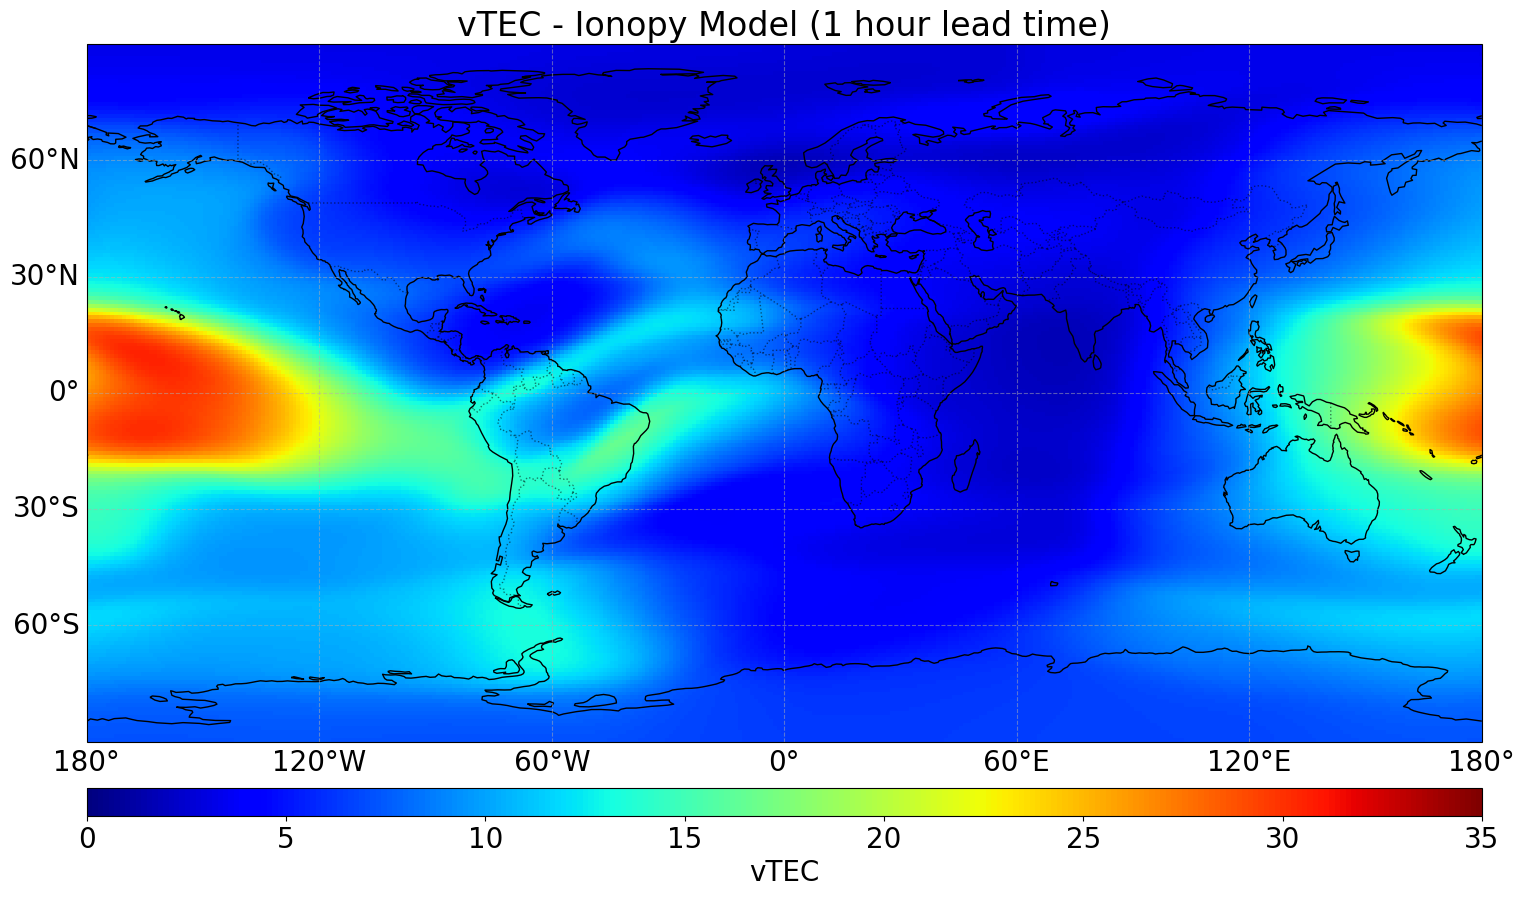

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# assuming targets is already a 2D array of TEC values
targets = np.stack(targets)

fig = plt.figure(figsize=(18, 12))
#change font:
plt.rcParams.update({'font.size': 20})

# Use PlateCarree for lat/lon projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the data
im = ax.imshow(
    targets,
    extent=(-180, 180, -90, 90),
    transform=ccrs.PlateCarree(),
    cmap='jet',
    origin='lower',
    vmin=0, 
    vmax=35
)

# Add coastlines and continents
ax.coastlines(resolution='110m', color='black')
ax.add_feature(cfeature.BORDERS, linestyle=':', alpha=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='white', alpha=0.3)

# Gridlines
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Colorbar
cbar = plt.colorbar(im, orientation='horizontal', pad=0.05, aspect=50)
cbar.set_label('vTEC')

# Title
plt.title('vTEC - Ionopy Model (1 hour lead time)')
plt.savefig(f'predicted_vtec_ionopy_model_{chosen_batch['date'][10]}.png', dpi=400)
plt.show()

In [57]:
new_batch.keys()

dict_keys(['date', 'inputs', 'tec', 'dtec', 'latitude_classification', 'jpld', 'omni_indices', 'omni_solar_wind', 'omni_magnetic_field', 'set_sw', 'solar_activity_classification', 'celestrack', 'storm_classification'])

In [21]:
next(iter(test_loader))

{'date': ['2011-02-01 00:02:30.000000',
  '2011-02-01 00:02:30.000000',
  '2011-02-01 00:02:30.000000',
  '2011-02-01 00:02:30.000000',
  '2011-02-01 00:07:30.000000',
  '2011-02-01 00:07:30.000000',
  '2011-02-01 00:07:30.000000',
  '2011-02-01 00:12:30.000000',
  '2011-02-01 00:17:30.000000',
  '2011-02-01 00:17:30.000000',
  '2011-02-01 00:17:30.000000',
  '2011-02-01 00:17:30.000000',
  '2011-02-01 00:17:30.000000',
  '2011-02-01 00:17:30.000000',
  '2011-02-01 00:17:30.000000',
  '2011-02-01 00:17:30.000000',
  '2011-02-01 00:17:30.000000',
  '2011-02-01 00:22:30.000000',
  '2011-02-01 00:27:30.000000',
  '2011-02-01 00:27:30.000000',
  '2011-02-01 00:27:30.000000',
  '2011-02-01 00:27:30.000000',
  '2011-02-01 00:32:30.000000',
  '2011-02-01 00:37:30.000000',
  '2011-02-01 00:37:30.000000',
  '2011-02-01 00:37:30.000000',
  '2011-02-01 00:42:30.000000',
  '2011-02-01 00:52:30.000000',
  '2011-02-01 00:57:30.000000',
  '2011-02-01 00:57:30.000000',
  '2011-02-01 00:57:30.000000',
